In [36]:
## Standard libraries
import os
import numpy as np
import random
from pathlib import Path
from random import sample
import json
from PIL import Image
from collections import defaultdict
from statistics import mean, stdev
from copy import deepcopy
from torch.utils.data import Dataset

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100, SVHN
from torchvision import transforms
import torch_directml

from torchvision.transforms import (
    Grayscale, ToTensor, Compose, Resize, InterpolationMode, Normalize, Lambda
)
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial16"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch_directml.device()
print("Device:", device)

C:\Users\bpele\AppData\Local\Temp\ipykernel_41184\3074855280.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: privateuseone:0


<Figure size 640x480 with 0 Axes>

In [37]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial16/"
# Files to download
pretrained_files = ["ProtoNet.ckpt", "ProtoMAML.ckpt",
                    "tensorboards/ProtoNet/events.out.tfevents.ProtoNet",
                    "tensorboards/ProtoMAML/events.out.tfevents.ProtoMAML",
                    "protomaml_fewshot.json", 
                    "protomaml_svhn_fewshot.json"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [53]:
import numpy as np
import torch
from collections import defaultdict
import random

class FewShotBatchSampler(object):
    def __init__(self, total_frames, frames_per_class, N_way, K_shot, num_classes=6, class_set=[], include_query=False, shuffle=True, shuffle_once=False, blocks=50000):
        """
        A batch sampler for few-shot learning, designed to sample batches of N-way K-shot examples.

        Args:
            total_frames (int): Total number of frames in the dataset.
            frames_per_class (int): Number of frames per class before repeating.
            N_way (int): Number of classes to sample per batch.
            K_shot (int): Number of examples to sample per class in the batch.
            num_classes (int, optional): Number of unique classes in a complete set before repeating. Defaults to 5.
            class_set (list, optional): List of classes to include in the sampling. Defaults to an empty list.
            include_query (bool, optional): If True, doubles the K_shot for support and query sets. Defaults to False.
            shuffle (bool, optional): If True, examples and classes are newly shuffled in each iteration (for training). Defaults to True.
            shuffle_once (bool, optional): If True, examples and classes are shuffled once at the beginning (for validation). Defaults to False.
            blocks (int, optional): Number of blocks to skip between selected indices. Defaults to 50000.
        """
        self.total_frames = total_frames
        self.frames_per_class = frames_per_class
        self.N_way = N_way
        self.K_shot = K_shot * 2 if include_query else K_shot
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.shuffle_once = shuffle_once
        self.include_query = include_query  # Ensure this attribute is correctly initialized
        self.classes = class_set
        self.num_blocks = blocks

        # Validate N_way against the number of available classes
        print("N_way is: ", N_way)
        print("class length: ", len(self.classes))
        if N_way > len(self.classes):
            raise ValueError("Number of sampled classes (N_way) cannot be larger than the number of available classes")

        self.indices_per_class = {}
        self.batches_per_class = {}

        frames_per_class = 150000
        num_classes_all = 6
        gain_step = frames_per_class * num_classes_all

        # Generate indices for each class and store them
        selected_indices = []
        for c in self.classes:
            start_frame = (c * frames_per_class)
            end_frame = (start_frame + frames_per_class)
            start_idx = start_frame
            end_idx = end_frame

            # Generate indices for this class and append to selected_indices
            selected_indices = np.arange(start_idx, end_idx, self.num_blocks)
            selected_indices = np.concatenate([
                selected_indices,
                np.arange(start_idx + gain_step, end_idx + gain_step, self.num_blocks),
                np.arange(start_idx + (2 * gain_step), end_idx + (2 * gain_step), self.num_blocks)
            ])
            self.indices_per_class[c] = selected_indices
            self.batches_per_class[c] = self.indices_per_class[c].shape[0] // self.K_shot
            selected_indices = []

        self.batch_size = self.N_way * self.K_shot
        self.iterations = sum(self.batches_per_class.values()) // self.N_way
        self.class_list = [c for c in self.classes for _ in range(self.batches_per_class[c])]

        # Shuffle data once if shuffle_once is set
        if shuffle_once:
            self.shuffle_data()

    def shuffle_data(self):
        """Shuffles the indices per class and the class list."""
        for c in self.classes:
            perm = torch.randperm(self.indices_per_class[c].shape[0])
            self.indices_per_class[c] = self.indices_per_class[c][perm]
        random.shuffle(self.class_list)
        # Shuffle the class list from which we sample. Note that this way of shuffling
        # does not prevent to choose the same class twice in a batch. However, for
        # training and validation, this is not a problem.
    def __iter__(self):
        """Yields batches of indices for the few-shot learning task."""
        if self.shuffle:
            self.shuffle_data()

        start_index = defaultdict(int)
        for it in range(self.iterations):
            class_batch = self.class_list[it * self.N_way : (it + 1) * self.N_way]  # Select N classes for the batch
            index_batch = []
            for c in class_batch:  # For each class, select the next K examples and add them to the batch
                index_batch.extend(self.indices_per_class[c][start_index[c] : start_index[c] + self.K_shot])
                start_index[c] += self.K_shot

            if self.include_query:  # If we return support + query set, sort them so that they are easy to split
                index_batch = index_batch[::2] + index_batch[1::2]

            yield index_batch

    def __len__(self):
        """Returns the number of iterations (batches) per epoch."""
        return self.iterations

In [39]:
class LanguageDataset(Dataset):
    """
    A PyTorch Dataset class for loading and processing spectrogram images of radio signals.

    This dataset:
    - Loads images from a specified directory.
    - Applies preprocessing transformations (grayscale conversion, resizing, normalization).
    - Computes class weights for handling class imbalance.
    - Returns image tensors along with their respective labels.

    Attributes:
    ----------
    data_dir : str
        Path to the dataset directory.
    class_labels : list
        List of signal class names.
    class_weights : torch.Tensor
        Normalized inverse frequency weights for each class.
    data_files : list
        List of all image file names in the dataset.
    transform : torchvision.transforms.Compose
        Transformations applied to each image.
    """

    def __init__(self, data_dir):
        """
        Initializes the dataset by loading class names, computing class frequencies, and setting up transformations.

        Parameters:
        ----------
        data_dir : str
            Path to the dataset directory.
        """
        self.data_dir = data_dir

        # Define class labels (must match the dataset naming convention)
        self.class_labels = [ 'arabic', 'english', 'german', 'mandarin', 'spanish']

        # Get all filenames from the dataset directory
        self.data_files = os.listdir(data_dir)

        # Compute class frequencies (how many samples per class exist)
        class_counts = {label: sum(1 for file in self.data_files if file.startswith(label)) for label in self.class_labels}

        # Compute class weights (inverse frequency) to handle class imbalance
        total_samples = sum(class_counts.values())
        class_weights = [1 / (count / total_samples) if count > 0 else 0 for count in class_counts.values()]

        # Normalize class weights so they sum to 1
        class_weights_sum = sum(class_weights)
        self.class_weights = torch.tensor([w / class_weights_sum for w in class_weights], dtype=torch.float)

        # Define image transformations
        self.transform = Compose([
            ToTensor(),
            Grayscale(num_output_channels=3),
            Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
            Normalize(mean=[0.5], std=[0.5])
        ])

    def __getitem__(self, index):
        """
        Loads an image, applies transformations, and returns it along with its label index.

        Parameters:
        ----------
        index : int
            Index of the sample in the dataset.

        Returns:
        -------
        tuple(torch.Tensor, torch.Tensor)
            Transformed image tensor and its corresponding label index.
        """
        # Get the filename of the sample
        file_name = self.data_files[index]
        file_path = os.path.join(self.data_dir, file_name)

        # Load the image
        image = Image.open(file_path)

        # Rotate 90 degrees (optional, remove if unnecessary)
        image = image.transpose(Image.ROTATE_90)

        # Ensure the image is in RGB mode (some formats might be grayscale)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Extract the class label from the filename
        class_label = file_name.split('_')[0]
        label_index = self.class_labels.index(class_label)

        # Apply transformations and return image with label
        return self.transform(image), torch.tensor(label_index, dtype=torch.long)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        -------
        int
            Number of files in the dataset.
        """
        return len(self.data_files)


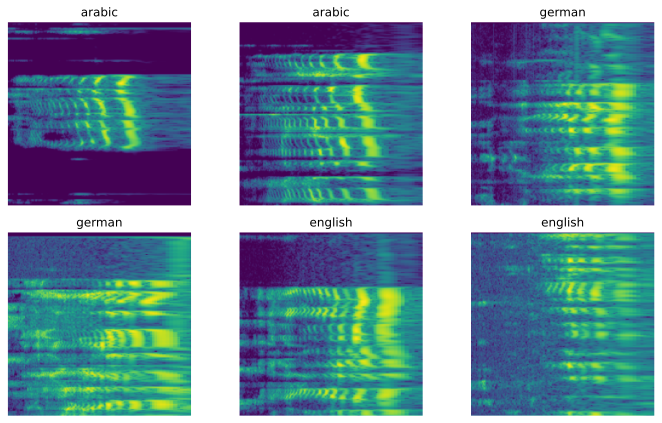

In [40]:
# Define the dataset path (Update if the path is different)
data_dir2 = Path("languages")
#data_dir2 = Path("/content/drive/MyDrive/ENDG_511_Lab2_Seleem_Badawy_Benjamin_Pele/data/radio_signal_identification/radio_signal_identification")

# List all spectrogram files in the directory
spectrogram_filenames = os.listdir(data_dir2)
# Number of spectrogram samples to visualize
num_samples = 6
# Randomly select 'num_samples' spectrogram files from the dataset
selected_files = sample(spectrogram_filenames, num_samples)

# Create a 2x3 grid for visualization
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)
# Iterate through selected files and plot spectrograms
for i, ax in enumerate(axes.ravel()):
    # Load spectrogram image
    spectrogram_path = os.path.join(data_dir2, selected_files[i])
    spectrogram = np.array(Image.open(spectrogram_path).convert("L").resize((224, 224))).T
    # Ensure the spectrogram has correct dimensions
    spectrogram = np.squeeze(spectrogram)
    # Display the spectrogram
    ax.imshow(spectrogram, cmap="viridis")  # Ensuring a grayscale colormap
    ax.set_title(selected_files[i].split('_')[0])  # Extract class label from filename
    ax.axis("off")  # Hide axes for better visualization

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [43]:
dataset = LanguageDataset(Path('languages'))  # Update path if needed
# Set random seed for reproducibility
seed = 42

# ⁉️Replace the line below with your stratified split implementation
dataset_train, dataset_val = random_split(dataset, [0.8, 0.2],
                                          generator=torch.Generator().manual_seed(seed))

In [51]:
torch.manual_seed(0)           # Set seed for reproducibility
classes = torch.randperm(6)  # Returns random permutation of numbers 0 to 99
train_classes, val_classes, test_classes = classes[:6], classes[4:6], classes[0:6]
print(train_classes)
print(val_classes)
print(test_classes)
train_n_blocks = 125
val_n_blocks = 1400
test_n_blocks = 450

print(len(train_classes.numpy()))

tensor([2, 5, 3, 0, 1, 4])
tensor([1, 4])
tensor([2, 5, 3, 0, 1, 4])
6


In [56]:
# Create DataLoader for training set
train_data_loader = data.DataLoader(
    dataset_train,
    batch_sampler=FewShotBatchSampler(
        total_frames=10800000,        # Total number of frames in the dataset
        frames_per_class=150000,      # Number of frames per class before repeating
        N_way=3,                      # Number of classes to sample per batch
        K_shot=4,                     # Number of examples to sample per class in the batch
        num_classes=len(train_classes),  # Total number of unique classes in the training set
        class_set=train_classes.numpy(), # Classes to include in sampling, adjusted based on dataset
        include_query=True,           # If True, doubles the K_shot for support and query sets
        shuffle=True,                 # Shuffle examples and classes in each iteration (for training)
        blocks=train_n_blocks         # Number of blocks to skip between selected indices
    ),
    num_workers=8  # Number of worker processes to use for data loading
)

# Create DataLoader for validation set
val_data_loader = data.DataLoader(
    dataset_val,
    batch_sampler=FewShotBatchSampler(
        total_frames=10800000,        # Total number of frames in the dataset
        frames_per_class=150000,      # Number of frames per class before repeating
        N_way=1,                     # Number of classes to sample per batch
        K_shot=3,                     # Number of examples to sample per class in the batch
        num_classes=len(val_classes), # Total number of unique classes in the validation set
        class_set=val_classes.numpy(),# Classes to include in sampling, adjusted based on dataset
        include_query=True,           # If True, doubles the K_shot for support and query sets
        shuffle=True,                 # Shuffle examples and classes in each iteration (for training)
        blocks=val_n_blocks           # Number of blocks to skip between selected indices
    ),
    num_workers=8  # Number of worker processes to use for data loading
)

# Print the number of batches in the training DataLoader
print(len(train_data_loader))

# Print the number of batches in the validation DataLoader
print(len(val_data_loader))

N_way is:  3
class length:  6
N_way is:  1
class length:  2
900
108


In [57]:
def split_batch(IQ, targets):
    """
    Splits a batch of IQ samples and targets into support and query sets.

    Args:
        IQ (Tensor): Batch of IQ samples, assumed to be of shape (2 * batch_size, ...).
        targets (Tensor): Batch of targets, assumed to be of shape (2 * batch_size, ...).

    Returns:
        Tuple[Tensor, Tensor, Tensor, Tensor]:
            - support_IQ (Tensor): Support set IQ samples of shape (batch_size, ...).
            - query_IQ (Tensor): Query set IQ samples of shape (batch_size, ...).
            - support_targets (Tensor): Support set targets of shape (batch_size, ...).
            - query_targets (Tensor): Query set targets of shape (batch_size, ...).
    """
    # Split the IQ samples tensor into support and query sets along the first dimension
    support_IQ, query_IQ = IQ.chunk(2, dim=0)

    # Split the targets tensor into support and query sets along the first dimension
    support_targets, query_targets = targets.chunk(2, dim=0)

    return support_IQ, query_IQ, support_targets, query_targets

In [58]:
def get_convnet(output_size):
    """
    Creates a DenseNet-based convolutional neural network for a specified output size.

    Args:
        output_size (int): The number of output classes for the classification task.

    Returns:
        torchvision.models.DenseNet: A DenseNet model configured with the specified output size.
    """
    # Create a DenseNet model with the specified configuration and output size
    convnet = torchvision.models.DenseNet(
        growth_rate=32,          # Number of filters to add each layer (growth rate)
        block_config=(5, 5, 5),  # Number of layers in each dense block
        bn_size=1,               # Multiplicative factor for bottleneck layers
        num_init_features=64,    # Number of filters in the initial convolution layer
        num_classes=output_size  # Output dimensionality
    )
    return convnet

In [59]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import pytorch_lightning as pl

class ProtoNet(pl.LightningModule):
    def __init__(self, proto_dim, lr):
        """
        Initializes the ProtoNet model.

        Args:
            proto_dim (int): Dimensionality of the prototype feature space.
            lr (float): Learning rate for the Adam optimizer.
        """
        super().__init__()
        self.save_hyperparameters()
        self.model = get_convnet(output_size=self.hparams.proto_dim)
        self.model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1), padding=(3, 3), bias=False)

    def configure_optimizers(self):
        """
        Configures the optimizers and learning rate scheduler.

        Returns:
            list: List of optimizers.
            list: List of learning rate schedulers.
        """
        optimizer = optim.AdamW(self.parameters(), lr=self.hparams.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 80], gamma=0.1)
        return [optimizer], [scheduler]

    @staticmethod
    def calculate_prototypes(features, targets):
        """
        Calculates class prototypes from features and targets.

        Args:
            features (Tensor): Tensor of shape [N, proto_dim] containing feature vectors.
            targets (Tensor): Tensor of shape [N] containing class labels.

        Returns:
            Tensor: Prototypes for each class.
            Tensor: Unique classes.
        """
        classes, _ = torch.unique(targets).sort()  # Determine which classes we have
        prototypes = []
        for c in classes:
            p = features[torch.where(targets == c)[0]].mean(dim=0)  # Average class feature vectors
            p = p / p.norm(dim=0, keepdim=True)  # Normalize the prototype
            prototypes.append(p)
        prototypes = torch.stack(prototypes, dim=0)
        return prototypes, classes

    def classify_feats(self, prototypes, classes, feats, targets):
        """
        Classifies new examples with prototypes and returns classification error.

        Args:
            prototypes (Tensor): Tensor containing class prototypes.
            classes (Tensor): Tensor containing unique class labels.
            feats (Tensor): Tensor containing feature vectors to classify.
            targets (Tensor): Tensor containing true class labels for the features.

        Returns:
            Tensor: Log-softmax predictions.
            Tensor: True labels.
            Tensor: Accuracy of the predictions.
        """
        dist = torch.pow(prototypes[None, :] - feats[:, None], 2).sum(dim=2)  # Squared Euclidean distance
        preds = F.log_softmax(-dist, dim=1)
        labels = (classes[None, :] == targets[:, None]).long().argmax(dim=-1)
        acc = (preds.argmax(dim=1) == labels).float().mean()
        return preds, labels, acc


    def calculate_loss(self, batch, mode):
        """
        Calculates training loss for a given support and query set.

        Args:
            batch (tuple): Tuple containing images and targets.
            mode (str): Mode for logging, e.g., "train" or "val".

        Returns:
            Tensor: Calculated loss.
        """
        iqs, targets = batch
        features = self.model(iqs)  # Encode all IQ samples of support and query set
        support_feats, query_feats, support_targets, query_targets = split_batch(features, targets)
        prototypes, classes = ProtoNet.calculate_prototypes(support_feats, support_targets)
        preds, labels, acc = self.classify_feats(prototypes, classes, query_feats, query_targets)
        loss = F.cross_entropy(preds, labels)
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        """
        Performs a single training step.

        Args:
            batch (tuple): Tuple containing images and targets.
            batch_idx (int): Index of the current batch.

        Returns:
            Tensor: Calculated loss for the batch.
        """
        return self.calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        """
        Performs a single validation step.

        Args:
            batch (tuple): Tuple containing images and targets.
            batch_idx (int): Index of the current batch.

        Returns:
            None
        """
        _ = self.calculate_loss(batch, mode="val")

In [60]:
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

def train_model(model_class, train_loader, val_loader, **kwargs):
    """
    Trains a PyTorch Lightning model with the specified training and validation data loaders.

    Args:
        model_class (pl.LightningModule): The class of the model to be trained.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
        **kwargs: Additional keyword arguments for the model class initialization.

    Returns:
        pl.LightningModule: The trained model.
    """
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, model_class.__name__),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=110,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch")
        ],
        enable_progress_bar=True
    )
    trainer.logger._default_hp_metric = None

    # Check whether a pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_class.__name__ + ".ckpt")
    print(pretrained_filename)
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        # Automatically loads the model with the saved hyperparameters
        model = model_class.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # Ensure reproducibility
        model = model_class(**kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = model_class.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)  # Load best checkpoint after training

    return model

In [61]:
# Train the ProtoNet model with specified parameters
protonet_model = train_model(
    ProtoNet,          # Model class to be trained
    proto_dim=128,     # Dimensionality of prototype feature space
    lr=1e-3,           # Learning rate for the optimizer
    train_loader=train_data_loader,  # DataLoader for the training data
    val_loader=val_data_loader       # DataLoader for the validation data
)
# Note: You can adjust the learning rate (lr) as needed, e.g., lr=2e-4

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\bpele\saved_models\tutorial16\ProtoNet.ckpt`


../saved_models/tutorial16\ProtoNet.ckpt
Found pretrained model at ../saved_models/tutorial16\ProtoNet.ckpt, loading...


RuntimeError: Error(s) in loading state_dict for ProtoNet:
	Unexpected key(s) in state_dict: "model.features.transition3.norm.weight", "model.features.transition3.norm.bias", "model.features.transition3.norm.running_mean", "model.features.transition3.norm.running_var", "model.features.transition3.norm.num_batches_tracked", "model.features.transition3.conv.weight", "model.features.denseblock4.denselayer1.norm1.weight", "model.features.denseblock4.denselayer1.norm1.bias", "model.features.denseblock4.denselayer1.norm1.running_mean", "model.features.denseblock4.denselayer1.norm1.running_var", "model.features.denseblock4.denselayer1.norm1.num_batches_tracked", "model.features.denseblock4.denselayer1.conv1.weight", "model.features.denseblock4.denselayer1.norm2.weight", "model.features.denseblock4.denselayer1.norm2.bias", "model.features.denseblock4.denselayer1.norm2.running_mean", "model.features.denseblock4.denselayer1.norm2.running_var", "model.features.denseblock4.denselayer1.norm2.num_batches_tracked", "model.features.denseblock4.denselayer1.conv2.weight", "model.features.denseblock4.denselayer2.norm1.weight", "model.features.denseblock4.denselayer2.norm1.bias", "model.features.denseblock4.denselayer2.norm1.running_mean", "model.features.denseblock4.denselayer2.norm1.running_var", "model.features.denseblock4.denselayer2.norm1.num_batches_tracked", "model.features.denseblock4.denselayer2.conv1.weight", "model.features.denseblock4.denselayer2.norm2.weight", "model.features.denseblock4.denselayer2.norm2.bias", "model.features.denseblock4.denselayer2.norm2.running_mean", "model.features.denseblock4.denselayer2.norm2.running_var", "model.features.denseblock4.denselayer2.norm2.num_batches_tracked", "model.features.denseblock4.denselayer2.conv2.weight", "model.features.denseblock4.denselayer3.norm1.weight", "model.features.denseblock4.denselayer3.norm1.bias", "model.features.denseblock4.denselayer3.norm1.running_mean", "model.features.denseblock4.denselayer3.norm1.running_var", "model.features.denseblock4.denselayer3.norm1.num_batches_tracked", "model.features.denseblock4.denselayer3.conv1.weight", "model.features.denseblock4.denselayer3.norm2.weight", "model.features.denseblock4.denselayer3.norm2.bias", "model.features.denseblock4.denselayer3.norm2.running_mean", "model.features.denseblock4.denselayer3.norm2.running_var", "model.features.denseblock4.denselayer3.norm2.num_batches_tracked", "model.features.denseblock4.denselayer3.conv2.weight", "model.features.denseblock4.denselayer4.norm1.weight", "model.features.denseblock4.denselayer4.norm1.bias", "model.features.denseblock4.denselayer4.norm1.running_mean", "model.features.denseblock4.denselayer4.norm1.running_var", "model.features.denseblock4.denselayer4.norm1.num_batches_tracked", "model.features.denseblock4.denselayer4.conv1.weight", "model.features.denseblock4.denselayer4.norm2.weight", "model.features.denseblock4.denselayer4.norm2.bias", "model.features.denseblock4.denselayer4.norm2.running_mean", "model.features.denseblock4.denselayer4.norm2.running_var", "model.features.denseblock4.denselayer4.norm2.num_batches_tracked", "model.features.denseblock4.denselayer4.conv2.weight", "model.features.denseblock4.denselayer5.norm1.weight", "model.features.denseblock4.denselayer5.norm1.bias", "model.features.denseblock4.denselayer5.norm1.running_mean", "model.features.denseblock4.denselayer5.norm1.running_var", "model.features.denseblock4.denselayer5.norm1.num_batches_tracked", "model.features.denseblock4.denselayer5.conv1.weight", "model.features.denseblock4.denselayer5.norm2.weight", "model.features.denseblock4.denselayer5.norm2.bias", "model.features.denseblock4.denselayer5.norm2.running_mean", "model.features.denseblock4.denselayer5.norm2.running_var", "model.features.denseblock4.denselayer5.norm2.num_batches_tracked", "model.features.denseblock4.denselayer5.conv2.weight", "model.features.denseblock4.denselayer6.norm1.weight", "model.features.denseblock4.denselayer6.norm1.bias", "model.features.denseblock4.denselayer6.norm1.running_mean", "model.features.denseblock4.denselayer6.norm1.running_var", "model.features.denseblock4.denselayer6.norm1.num_batches_tracked", "model.features.denseblock4.denselayer6.conv1.weight", "model.features.denseblock4.denselayer6.norm2.weight", "model.features.denseblock4.denselayer6.norm2.bias", "model.features.denseblock4.denselayer6.norm2.running_mean", "model.features.denseblock4.denselayer6.norm2.running_var", "model.features.denseblock4.denselayer6.norm2.num_batches_tracked", "model.features.denseblock4.denselayer6.conv2.weight", "model.features.denseblock1.denselayer6.norm1.weight", "model.features.denseblock1.denselayer6.norm1.bias", "model.features.denseblock1.denselayer6.norm1.running_mean", "model.features.denseblock1.denselayer6.norm1.running_var", "model.features.denseblock1.denselayer6.norm1.num_batches_tracked", "model.features.denseblock1.denselayer6.conv1.weight", "model.features.denseblock1.denselayer6.norm2.weight", "model.features.denseblock1.denselayer6.norm2.bias", "model.features.denseblock1.denselayer6.norm2.running_mean", "model.features.denseblock1.denselayer6.norm2.running_var", "model.features.denseblock1.denselayer6.norm2.num_batches_tracked", "model.features.denseblock1.denselayer6.conv2.weight", "model.features.denseblock2.denselayer6.norm1.weight", "model.features.denseblock2.denselayer6.norm1.bias", "model.features.denseblock2.denselayer6.norm1.running_mean", "model.features.denseblock2.denselayer6.norm1.running_var", "model.features.denseblock2.denselayer6.norm1.num_batches_tracked", "model.features.denseblock2.denselayer6.conv1.weight", "model.features.denseblock2.denselayer6.norm2.weight", "model.features.denseblock2.denselayer6.norm2.bias", "model.features.denseblock2.denselayer6.norm2.running_mean", "model.features.denseblock2.denselayer6.norm2.running_var", "model.features.denseblock2.denselayer6.norm2.num_batches_tracked", "model.features.denseblock2.denselayer6.conv2.weight", "model.features.denseblock3.denselayer6.norm1.weight", "model.features.denseblock3.denselayer6.norm1.bias", "model.features.denseblock3.denselayer6.norm1.running_mean", "model.features.denseblock3.denselayer6.norm1.running_var", "model.features.denseblock3.denselayer6.norm1.num_batches_tracked", "model.features.denseblock3.denselayer6.conv1.weight", "model.features.denseblock3.denselayer6.norm2.weight", "model.features.denseblock3.denselayer6.norm2.bias", "model.features.denseblock3.denselayer6.norm2.running_mean", "model.features.denseblock3.denselayer6.norm2.running_var", "model.features.denseblock3.denselayer6.norm2.num_batches_tracked", "model.features.denseblock3.denselayer6.conv2.weight". 
	size mismatch for model.features.conv0.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 1, 2, 2]).
	size mismatch for model.features.denseblock1.denselayer1.conv1.weight: copying a param with shape torch.Size([64, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 64, 1, 1]).
	size mismatch for model.features.denseblock1.denselayer1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer1.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer1.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer1.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock1.denselayer2.conv1.weight: copying a param with shape torch.Size([64, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 96, 1, 1]).
	size mismatch for model.features.denseblock1.denselayer2.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer2.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer2.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer2.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer2.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock1.denselayer3.conv1.weight: copying a param with shape torch.Size([64, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 128, 1, 1]).
	size mismatch for model.features.denseblock1.denselayer3.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer3.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer3.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer3.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer3.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock1.denselayer4.conv1.weight: copying a param with shape torch.Size([64, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 160, 1, 1]).
	size mismatch for model.features.denseblock1.denselayer4.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer4.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer4.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer4.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer4.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock1.denselayer5.conv1.weight: copying a param with shape torch.Size([64, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 192, 1, 1]).
	size mismatch for model.features.denseblock1.denselayer5.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer5.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer5.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer5.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock1.denselayer5.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.transition1.norm.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for model.features.transition1.norm.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for model.features.transition1.norm.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for model.features.transition1.norm.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([224]).
	size mismatch for model.features.transition1.conv.weight: copying a param with shape torch.Size([128, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([112, 224, 1, 1]).
	size mismatch for model.features.denseblock2.denselayer1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for model.features.denseblock2.denselayer1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for model.features.denseblock2.denselayer1.norm1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for model.features.denseblock2.denselayer1.norm1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for model.features.denseblock2.denselayer1.conv1.weight: copying a param with shape torch.Size([64, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 112, 1, 1]).
	size mismatch for model.features.denseblock2.denselayer1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer1.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer1.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer1.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock2.denselayer2.norm1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for model.features.denseblock2.denselayer2.norm1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for model.features.denseblock2.denselayer2.norm1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for model.features.denseblock2.denselayer2.norm1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for model.features.denseblock2.denselayer2.conv1.weight: copying a param with shape torch.Size([64, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 144, 1, 1]).
	size mismatch for model.features.denseblock2.denselayer2.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer2.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer2.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer2.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer2.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock2.denselayer3.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for model.features.denseblock2.denselayer3.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for model.features.denseblock2.denselayer3.norm1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for model.features.denseblock2.denselayer3.norm1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([176]).
	size mismatch for model.features.denseblock2.denselayer3.conv1.weight: copying a param with shape torch.Size([64, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 176, 1, 1]).
	size mismatch for model.features.denseblock2.denselayer3.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer3.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer3.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer3.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer3.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock2.denselayer4.norm1.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for model.features.denseblock2.denselayer4.norm1.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for model.features.denseblock2.denselayer4.norm1.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for model.features.denseblock2.denselayer4.norm1.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([208]).
	size mismatch for model.features.denseblock2.denselayer4.conv1.weight: copying a param with shape torch.Size([64, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 208, 1, 1]).
	size mismatch for model.features.denseblock2.denselayer4.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer4.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer4.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer4.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer4.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock2.denselayer5.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for model.features.denseblock2.denselayer5.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for model.features.denseblock2.denselayer5.norm1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for model.features.denseblock2.denselayer5.norm1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([240]).
	size mismatch for model.features.denseblock2.denselayer5.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 240, 1, 1]).
	size mismatch for model.features.denseblock2.denselayer5.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer5.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer5.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer5.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock2.denselayer5.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.transition2.norm.weight: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for model.features.transition2.norm.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for model.features.transition2.norm.running_mean: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for model.features.transition2.norm.running_var: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([272]).
	size mismatch for model.features.transition2.conv.weight: copying a param with shape torch.Size([160, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([136, 272, 1, 1]).
	size mismatch for model.features.denseblock3.denselayer1.norm1.weight: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for model.features.denseblock3.denselayer1.norm1.bias: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for model.features.denseblock3.denselayer1.norm1.running_mean: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for model.features.denseblock3.denselayer1.norm1.running_var: copying a param with shape torch.Size([160]) from checkpoint, the shape in current model is torch.Size([136]).
	size mismatch for model.features.denseblock3.denselayer1.conv1.weight: copying a param with shape torch.Size([64, 160, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 136, 1, 1]).
	size mismatch for model.features.denseblock3.denselayer1.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer1.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer1.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer1.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer1.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock3.denselayer2.norm1.weight: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([168]).
	size mismatch for model.features.denseblock3.denselayer2.norm1.bias: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([168]).
	size mismatch for model.features.denseblock3.denselayer2.norm1.running_mean: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([168]).
	size mismatch for model.features.denseblock3.denselayer2.norm1.running_var: copying a param with shape torch.Size([192]) from checkpoint, the shape in current model is torch.Size([168]).
	size mismatch for model.features.denseblock3.denselayer2.conv1.weight: copying a param with shape torch.Size([64, 192, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 168, 1, 1]).
	size mismatch for model.features.denseblock3.denselayer2.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer2.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer2.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer2.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer2.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock3.denselayer3.norm1.weight: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for model.features.denseblock3.denselayer3.norm1.bias: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for model.features.denseblock3.denselayer3.norm1.running_mean: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for model.features.denseblock3.denselayer3.norm1.running_var: copying a param with shape torch.Size([224]) from checkpoint, the shape in current model is torch.Size([200]).
	size mismatch for model.features.denseblock3.denselayer3.conv1.weight: copying a param with shape torch.Size([64, 224, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 200, 1, 1]).
	size mismatch for model.features.denseblock3.denselayer3.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer3.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer3.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer3.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer3.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock3.denselayer4.norm1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for model.features.denseblock3.denselayer4.norm1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for model.features.denseblock3.denselayer4.norm1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for model.features.denseblock3.denselayer4.norm1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([232]).
	size mismatch for model.features.denseblock3.denselayer4.conv1.weight: copying a param with shape torch.Size([64, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 232, 1, 1]).
	size mismatch for model.features.denseblock3.denselayer4.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer4.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer4.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer4.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer4.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.denseblock3.denselayer5.norm1.weight: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([264]).
	size mismatch for model.features.denseblock3.denselayer5.norm1.bias: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([264]).
	size mismatch for model.features.denseblock3.denselayer5.norm1.running_mean: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([264]).
	size mismatch for model.features.denseblock3.denselayer5.norm1.running_var: copying a param with shape torch.Size([288]) from checkpoint, the shape in current model is torch.Size([264]).
	size mismatch for model.features.denseblock3.denselayer5.conv1.weight: copying a param with shape torch.Size([64, 288, 1, 1]) from checkpoint, the shape in current model is torch.Size([32, 264, 1, 1]).
	size mismatch for model.features.denseblock3.denselayer5.norm2.weight: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer5.norm2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer5.norm2.running_mean: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer5.norm2.running_var: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for model.features.denseblock3.denselayer5.conv2.weight: copying a param with shape torch.Size([32, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for model.features.norm5.weight: copying a param with shape torch.Size([368]) from checkpoint, the shape in current model is torch.Size([296]).
	size mismatch for model.features.norm5.bias: copying a param with shape torch.Size([368]) from checkpoint, the shape in current model is torch.Size([296]).
	size mismatch for model.features.norm5.running_mean: copying a param with shape torch.Size([368]) from checkpoint, the shape in current model is torch.Size([296]).
	size mismatch for model.features.norm5.running_var: copying a param with shape torch.Size([368]) from checkpoint, the shape in current model is torch.Size([296]).
	size mismatch for model.classifier.weight: copying a param with shape torch.Size([64, 368]) from checkpoint, the shape in current model is torch.Size([64, 296]).

In [ ]:
# 🔧 Enhanced Encoder with Projection Head

import torch.nn as nn
from torchvision import models

class EnhancedPrototypicalEncoder(nn.Module):
    def __init__(self, output_dim=128):
        super().__init__()
        base_model = models.mobilenet_v2(pretrained=True)
        self.backbone = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.projector = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.projector(x)
        x = F.normalize(x, p=2, dim=-1)
        return x


In [ ]:
# 📐 Cosine Prototypical Loss with Label Smoothing

def cosine_prototypical_loss(support, query, support_labels, query_labels, n_classes, n_support):
    # Compute class prototypes
    prototypes = []
    for i in range(n_classes):
        class_support = support[support_labels == i]
        prototypes.append(class_support.mean(dim=0))
    prototypes = torch.stack(prototypes)

    # Normalize prototypes and query embeddings
    prototypes = F.normalize(prototypes, p=2, dim=-1)
    query = F.normalize(query, p=2, dim=-1)

    # Compute cosine similarity
    logits = torch.matmul(query, prototypes.T)
    logits /= 0.1  # temperature scaling

    loss = F.cross_entropy(logits, query_labels, label_smoothing=0.1)
    return loss, logits


In [ ]:
# 🎛️ Spectrogram Augmentation Transform

import torchvision.transforms as T

spec_augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomApply([T.RandomAffine(degrees=10, translate=(0.05, 0.05))], p=0.5),
])
